## Tutorial 3 - The Kernel class

After importing/defining everything in the Survey and FID classes the kernel
class is used for the computation of the kernel functions.

If a simple synthetic case is conducted, the class remains hidden, however
it is important to know how it works and what it does understand COMET.

In [3]:
# make sure graphics are plotted
%matplotlib inline 
# import comet submodules
from comet import pyhed as ph
from comet import snmr
import numpy as np # numerics
import matplotlib.pyplot as plt # plotting

ph.log.setLevel(20)

#### Setting up the geometry
We first initialize some material that is covered by the first two tutorials.
For the kernel, we assume three half overlapping 20x20m sized loops.
All 9 combinations for FID's are considered.

In [4]:
loop0 = ph.loop.buildRectangle([[-40, -20], [0, 20]], max_length=2)
loop1 = ph.loop.buildRectangle([[-20, -20], [20, 20]], max_length=2)
loop2 = ph.loop.buildRectangle([[0, -20], [40, 20]], max_length=2)
site = snmr.survey.Survey()
site.addLoop([loop0, loop1, loop2])
site.setEarth(mag=48000e-9, incl=60, decl=0)
config = ph.config(rho=[1000, 10], d=[10], f=site.earth.larmor)
site.setLoopConfig(config)
for tx_i in range(3):
    for rx_i in range(3):
        site.createSounding(tx=tx_i, rx=rx_i)

print(site)

SNMR Survey: 3 loops , 9 soundings


In [6]:
# Now we create a 1D kernel for the first FID
kern = site.createKernel(fid=0, dimension=1)
# This returns a Kernel class. let's take a look
print(kern)
# It contains references to the survey, loops and FIDs.
# Changes of survey parameters are made there and piped to the kernel.

survey: SNMR Survey: 3 loops , 9 soundings
fid: FID(Tx: 0, Rx: 0)
earth: earth, incl: 60.0°, decl: 0.0°, mag: 48000 nT
Tx: closed rectangle, 84 dipoles at (-20.0, -0.0, 0.0), 40.0 x 40.0 m
config: layered earth, 2 layers @ 2043.6869791707677 Hz, magnetic, B
Rx: coincident
dimension: 1\nKernel Matrix not calculated yet.


In [ ]:
# Let's have a look at the features of the kernel class,
# e.g. z discretization for a 1D kernel.
kern.createZVector(90, -60, min_thk=0.5)  ## better keywords?

This creates a z-vector in 90 steps up to 60 meter depth. The layers are spaced using a sinus hyperbolicus function (more linear compared to log, which is nicer at larger depth). 
The min_thk specifies the thickness of the final kernel discretization. Small layers around z = 0 are combined until each layer is at least 0.5m thick, which is better for inversions later. By summing up the values for the small thicknesses we obtain a more accurate kernel function in the shallow subsurface. 
By `kern.setZVector()` the z vector can be set arbitrarily.

In [8]:
print(kern.zvec) # z always positive upwards

[  0.          -0.5573965   -1.11068032  -1.65288414  -2.23159808
  -2.80657824  -3.31988333  -3.91791712  -4.61594236  -5.14552247
  -5.73339912  -6.38623268  -7.11141949  -7.91717558  -8.81262984
  -9.80792736 -10.3464936  -10.91434444 -11.51308711 -12.1444163
 -12.8101189  -13.51207911 -14.25228376 -15.03282791 -15.85592081
 -16.72389212 -17.63919855 -18.60443076 -19.62232074 -20.69574951
 -21.8277553  -23.02154211 -24.28048884 -25.60815878 -27.00830976
 -28.48490476 -30.0421231  -31.68437233 -33.41630064 -35.24281007
 -37.16907034 -39.20053353 -41.34294946 -43.602382   -45.98522623
 -48.49822651 -51.14849562 -53.94353485 -56.89125525 -60.        ]


In [10]:
# With this a mesh can be generated.
kern.create1DKernelMesh()
# There are a lot of options, however we build a default mesh.
print(kern.kernelMesh1D)

Mesh: Nodes: 12734 Cells: 25360 Boundaries: 38093


In [11]:
# Now we calulate the kernel function using 4 CPUs
kern.calculate(num_cpu=4)
# First, it requests a magnetic field for all involved loops (here only 0).
# If it does not exist none already, it will trigger the computation 
# following the supply-and-demand principle.
# This in turn requires a mesh, so it will be created.
# Last, the kernel for FID 0 is computed.
# Even the calls 
# kern.create1DKernelMesh()
# kern.createZVector(...) 
# are not needed, because they will be triggered using default parameters.

27/11/19 - 08:39:03 - comet - INFO - Calculating magnetic field of tx for 1D-kernel on nodes. ...
27/11/19 - 08:39:03 - comet - INFO - No Loop Mesh given or found. Creating.
27/11/19 - 08:39:03 - comet - INFO - createLoopMesh()


calling: "tetgen"
  _default_LoopMesh_rectangle_84.poly  -pzQAfq1.20a674.180326k
tetgen is finished: True


27/11/19 - 08:39:14 - comet - INFO - loopmesh.save: _default_LoopMesh_rectangle_84.bms
27/11/19 - 08:39:14 - comet - INFO - detecting non-grounded loop, set mode to "te"
27/11/19 - 08:39:14 - comet - INFO - Calculating loop field of closed rectangle, 84 dipoles at (-20.0, -0.0, 0.0), 40.0 x 40.0 m
27/11/19 - 08:39:14 - comet - INFO - config: layered earth, 2 layers @ 2043.6869791707677 Hz, magnetic, B
27/11/19 - 08:39:14 - comet - INFO - Start calculating in 4 parallel processes.
27/11/19 - 08:40:41 - comet - INFO - total field calculation time: 98.36 seconds
27/11/19 - 08:40:41 - comet - INFO - Get 90 slices... start calculating in 4 parallel processes.
27/11/19 - 08:41:07 - comet - INFO - overall calculation time: 124.3987 seconds


In [13]:
# Have a look at the kernels properties 
print(kern)

survey: SNMR Survey: 3 loops , 9 soundings
fid: FID(Tx: 0, Rx: 0)
earth: earth, incl: 60.0°, decl: 0.0°, mag: 48000 nT
Tx: closed rectangle, 84 dipoles at (-20.0, -0.0, 0.0), 40.0 x 40.0 m
config: layered earth, 2 layers @ 2043.6869791707677 Hz, magnetic, B
Rx: coincident
dimension: 1
Kernel Matrix pulse Moments: 24 
Kernel Matrix layers: 90


27/11/19 - 08:45:24 - comet - INFO - Kernel.show(1D): pcolormesh
27/11/19 - 08:45:24 - comet - INFO - Kernel.show(1D): pcolormesh


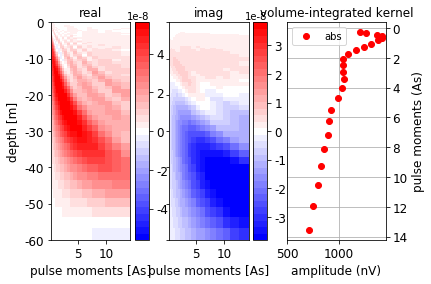

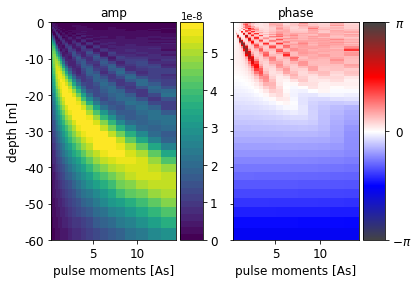

In [16]:
# and at the kernel matrix itself
kern.show(toplot=['real', 'imag', '0D']);
# alternatively, amplitude and phase kernels can be plotted
kern.show(toplot=['amp', 'phase']);

In [17]:
kern.save(savename='kern_fid_0')
# saves kernel class including mesh and kernel matrix, but excluding survey
# and FID (just the references are saved == indices to the correct loops
# and the FID). A backup of the pulse moments is saved with the kernel but
# discarded, once the survey is loaded and connected back to the kernel.

27/11/19 - 08:47:11 - comet - INFO - Save Kernel: kern_fid_0
27/11/19 - 08:47:11 - comet - INFO - save kernelmesh1D: kern_fid_0_kern1D.bms


In [19]:
# At a later stage, we can create a new kernel by loading
kern2 = snmr.kernel.Kernel(name='kern_fid_0')
print(kern2)
# Note the empty survey class and a None FID, no loops are known,
# plotting and inversion would be possible, but a recalculation fails

27/11/19 - 08:48:05 - comet - INFO - load file: c:\Guenther.T\src\comet\tutorials\kern_fid_0.npz


survey: SNMR Survey: 0 loops , 0 soundings
fid: None
earth: earth, incl: 60.0°, decl: 2.0°, mag: 48000 nT
Tx: None
Rx: coincident
dimension: 1
Kernel Matrix pulse Moments: 24 
Kernel Matrix layers: 90


In [23]:
# We can fix this by reconnecting with survey and FID
kern2.setSurvey(site, fid=0)
print(kern2)
# now we are back at the previous stage (kern2==kern)

survey: SNMR Survey: 3 loops , 9 soundings
fid: FID(Tx: 0, Rx: 0)
earth: earth, incl: 60.0°, decl: 0.0°, mag: 48000 nT
Tx: closed rectangle, 84 dipoles at (-20.0, -0.0, 0.0), 40.0 x 40.0 m
config: layered earth, 2 layers @ 2043.6869791707677 Hz, magnetic, B
Rx: coincident
dimension: 1
Kernel Matrix pulse Moments: 24 
Kernel Matrix layers: 90
